# First order methods for regression models

## Aim

The aim of this practical is to implement:
- gradient descent (GD);
- accelerated gradient descent (AGD);
- coordinate gradient descent (CD);
- stochastic gradient descent (SGD);
- stochastic variance reduced gradient descent (SVRG);

for the linear regression and logistic regression models, with the ridge penalization.

# Table of content

[1. Introduction](#intro)<br>
[2. Models gradients and losses](#models)<br>
[3. Solvers](#solvers)<br>
[4. Comparison of all algorithms](#comparison)<br>

<a id='intro'></a>
# 1. Introduction

## 1.1. Getting model weights

We'll start by generating sparse vectors and simulating data.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

## 1.2. Simulation of a linear model

In [0]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(w0, n_samples=1000, corr=0.5, std=0.5):
    """Simulation of a linear regression model with Gaussian features
    and a Toeplitz covariance, with Gaussian noise.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features
    
    std : `float`, default=0.5
        Standard deviation of the noise

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian  vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    y = X.dot(w0) + std * randn(n_samples)
    return X, y

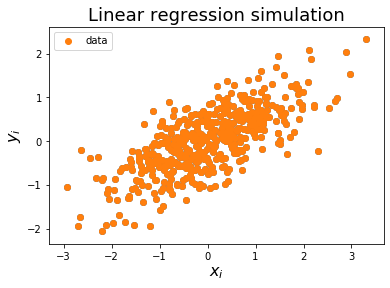

In [0]:
n_samples = 500
w0 = np.array([0.5])

X, y = simu_linreg(w0, n_samples=n_samples, corr=0.3, std=0.5)
plt.scatter(X, y)
plt.xlabel(r"$x_i$", fontsize=16)
plt.ylabel(r"$y_i$", fontsize=16)
plt.title("Linear regression simulation", fontsize=18)
plt.scatter(X, y, label='data')
plt.legend()

## 1.3. Simulation of a logistic regression model

In [0]:
def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)    
    out[idx] = 1 / (1. + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(w0, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model with Gaussian features
    and a Toeplitz covariance.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    cov = toeplitz(corr ** np.arange(0, n_features))
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(X.dot(w0))
    y = np.random.binomial(1, p, size=n_samples)
    # Put the label in {-1, 1}
    y[:] = 2 * y - 1
    return X, y

Text(0.5, 1.0, 'Logistic regression simulation')

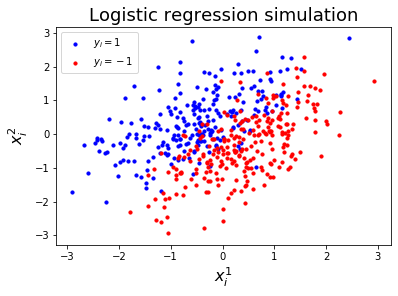

In [0]:
n_samples = 500
w0 = np.array([-3, 3.])

X, y = simu_logreg(w0, n_samples=n_samples, corr=0.4)

plt.scatter(*X[y == 1].T, color='b', s=10, label=r'$y_i=1$')
plt.scatter(*X[y == -1].T, color='r', s=10, label=r'$y_i=-1$')
plt.legend(loc='upper left')
plt.xlabel(r"$x_i^1$", fontsize=16)
plt.ylabel(r"$x_i^2$", fontsize=16)
plt.title("Logistic regression simulation", fontsize=18)

<a id='models'></a>
# 2. Models gradients and losses

We want to minimize a goodness-of-fit function $h$ with ridge regularization, namely
$$
\arg\min_{w \in \mathbb R^d} \Big\{ h(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}
$$
where $d$ is the number of features and where we will assume that $h$ is $L$-smooth.
We will consider below the following cases.

**Linear regression**, where 
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{2n} \sum_{i=1}^n (y_i - x_i^\top w)^2 + \frac{\lambda}{2} \|w\|_2^2 = \frac{1}{2 n} \| y - X w \|_2^2 + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, $y = [y_1 \cdots y_n]$ is the vector of labels and $X$ is the matrix of features with lines containing the features vectors $x_i \in \mathbb R^d$.

**Logistic regression**, where
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i x_i^\top w)) + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, and where labels $y_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f(w)$ and its gradient $\nabla f(w)$, in order to solve this problem, as well as $\nabla f_i(w)$ for stochastic gradient descent methods and $\frac{\partial f(w)}{\partial w_j}$ for coordinate descent.

Below is the full implementation for linear regression.

## 2.1 Linear regression

In [0]:
from numpy.linalg import norm


class ModelLinReg:
    """A class giving first order information for linear regression
    with least-squares loss
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return 0.5 * norm(y - X.dot(w)) ** 2 / n_samples + strength * norm(w) ** 2 / 2
    
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X.T.dot(X.dot(w) - y) / n_samples + strength * w

    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i]
        return (x_i.dot(w) - y[i]) * x_i + self.strength * w

    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X[:, j].T.dot(X.dot(w) - y) / n_samples + strength * w[j]

    def lip(self):
        """Computes the Lipschitz constant of the gradient of f"""
        X, n_samples = self.X, self.n_samples
        return norm(X.T.dot(X), 2) / n_samples + self.strength

    def lip_coordinates(self):
        """Computes the Lipschitz constant of the partial derivative of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples
        return (X ** 2).sum(axis=0) / n_samples + self.strength
        
    def lip_max(self):
        """Computes the maximum of the lipschitz constants of the gradient of f_i"""
        X, n_samples = self.X, self.n_samples
        return ((X ** 2).sum(axis=1) + self.strength).max()

## 2.2 Checks for the linear regression model

Text(0.5, 1.0, 'Model weights')

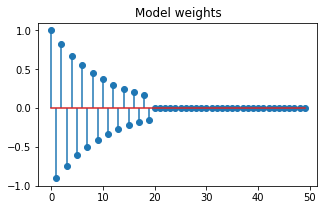

In [0]:
## Simulation setting
n_features = 50
nnz = 20
idx = np.arange(n_features)
w0 = (-1) ** idx * np.exp(-idx / 10.)
w0[nnz:] = 0.

plt.figure(figsize=(5, 3))
plt.stem(w0, use_line_collection=True)
plt.title("Model weights")

In [0]:
from scipy.optimize import check_grad

X, y = simu_linreg(w0, corr=0.6)
model = ModelLinReg(X, y, strength=1e-3)

w = np.random.randn(n_features)

print(check_grad(model.loss, model.grad, w)) # This must be a number (of order 1e-6)

2.436117099473151e-06


In [0]:
print("lip=", model.lip())
print("lip_max=", model.lip_max())
print("lip_coordinates=", model.lip_coordinates())

lip= 4.185409275453197
lip_max= 135.6523321735805
lip_coordinates= [0.95 0.99 1.04 1.01 1.08 1.02 1.03 1.05 1.02 1.07 1.03 1.   1.02 1.01
 1.   1.01 1.03 1.02 0.99 0.95 1.   1.01 1.03 1.   1.03 0.98 1.04 0.99
 0.96 0.94 1.   1.   0.95 0.99 0.98 0.96 0.91 0.9  1.   0.97 1.04 1.02
 0.94 1.05 1.05 0.95 1.02 0.99 1.03 1.01]


## 2.3 Logistic regression

### QUESTIONS

1. Compute (on paper) the gradient $\nabla f$, the gradient of $\nabla f_i$ and the gradient of the coordinate function $\frac{\partial f(w)}{\partial w_j}$ of $f$ for logistic regression (fill the class given below).

2. Fill in the functions below for the computation of $f$, $\nabla f$, $\nabla f_i$ and $\frac{\partial f(w)}{\partial w_j}$ for logistic regression in the ModelLogReg class below (fill between the TODO and END TODO).

**Answer:**
…

In [0]:
# Answer
class ModelLogReg:
    """A class giving first order information for logistic regression
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        return (1/n_samples)*np.sum(np.log(1+ np.exp(-y * (X @ w)))) + (strength/2)*(norm(w))**2 
        ### END TODO
       
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        return (1/n_samples)*np.sum(np.array([self.grad_i(i,w) for i in range(n_samples)]), axis = 0) + strength*w 
        ### END TODO

    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i]
        ### TODO
        return -y[i]*x_i*(1/(1 + np.exp(y[i]*x_i.T @ w)))
        ### END TODO

    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        return (1/n_samples)*np.sum(-y*X[:,j].T*(1/(1 + np.exp(y*(X @ w))))) + strength*w[j]
        ### END TODO

    def lip(self):
        """Computes the Lipschitz constant of the gradient of f"""
        X, n_samples = self.X, self.n_samples
        ### TODO
        return (1/4)*max((1/n_samples)*np.linalg.eigvals(X.T @ X)) + self.strength
        #The 1/4 factor corresponds with the upper bound of the sigmoid function
        ### END TODO

    def lip_coordinates(self):
        """Computes the Lipschitz constant of the partial derivative of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples
        ### TODO
        return (1/4)*((X ** 2).sum(axis=0) / n_samples) + self.strength
        ### END TODO

    def lip_max(self):
        """Computes the maximum of the lipschitz constants of gradient of f_i"""
        X, n_samples = self.X, self.n_samples
        ### TODO
        return (1/4)*((X ** 2).sum(axis=1)).max() +  self.strength
        ### END TODO

## 2.4 Checks for the logistic regression model

### QUESTIONS

1. Check numerically the gradient using the function ``checkgrad`` from ``scipy.optimize`` (see below), as we did for linear regression above.

**Remark**: use the function `simu_logreg` to simulate data according to the logistic regression model.

In [0]:
# Answer
from scipy.optimize import check_grad

X, y = simu_logreg(w0, corr=0.6)
model = ModelLogReg(X, y, strength=1e-3)

w = np.random.randn(n_features)

print(check_grad(model.loss, model.grad, w)) # This must be a number (of order 1e-6)

1.5274870285555298e-07


In [0]:
print("lip=", model.lip())
print("lip_max=", model.lip_max())
print("lip_coordinates=", model.lip_coordinates())

lip= 1.0387585173021838
lip_max= 27.55560309101156
lip_coordinates= [0.23 0.22 0.25 0.24 0.24 0.23 0.25 0.25 0.22 0.25 0.24 0.24 0.26 0.24
 0.25 0.25 0.28 0.26 0.25 0.26 0.27 0.25 0.26 0.26 0.25 0.26 0.25 0.24
 0.24 0.27 0.25 0.25 0.24 0.23 0.25 0.23 0.24 0.25 0.26 0.25 0.26 0.27
 0.24 0.26 0.26 0.24 0.25 0.23 0.25 0.25]


<a id='solvers'></a>
## 3. Solvers

We now have classes `ModelLinReg` and `ModelLogReg` that allow to compute $f(w)$, $\nabla f(w)$, 
$\nabla f_i(w)$ and $\frac{\partial f(w)}{\partial w_j}$ for the objective $f$
given by linear and logistic regression.

We want now to implement and compare several solvers to minimize $f$.

<a id='tools'></a>
## 3.1. Tools for the solvers

In [0]:
# Starting point of all solvers
w0 = np.zeros(model.n_features)

# Number of iterations
n_iter = 50

# Random samples indices for the stochastic solvers (sgd, sag, svrg)
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [0]:
def inspector(model, n_iter, verbose=True):
    """A closure called to update metrics after each iteration.
    Don't even look at it, we'll just use it in the solvers."""
    objectives = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(w):
        obj = model.loss(w)
        objectives.append(obj)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8)]))
            it[0] += 1
    inspector_cl.objectives = objectives
    return inspector_cl

<a id='gd'></a>
## 3.2 Gradient descent

### QUESTIONS

1. Finish the function `gd` below that implements the gradient descent algorithm.
1. Test it using the next cell.

Gradient descent formula : \\
$w_{k+1} = w_k - \alpha * \nabla f(w_k)$ with $\alpha$ the learning rate

In [0]:
# Answer
def gd(model, w0, n_iter, callback, verbose=True):
    """Gradient descent
    """
    step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    if verbose:
        print("Lauching GD solver...")
    callback(w)
    for k in range(n_iter + 1):
        w = w - step * model.grad(w)
        callback(w)
    return w

In [0]:
callback_gd = inspector(model, n_iter=n_iter)
w_gd = gd(model, w0, n_iter=n_iter, callback=callback_gd)

Lauching GD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 5.74e-01
      20 | 5.43e-01
      30 | 5.30e-01
      40 | 5.24e-01
      50 | 5.21e-01


<a id='agd'></a>
## 3.3 Accelerated gradient descent

### QUESTIONS

1. Finish the function `agd` below that implements the accelerated gradient descent algorithm.
1. Test it using the next cell.

Accelerated gradient descent formula : \\
$w_{k+1/2} = w_k - \alpha * \nabla f(w_k)$ \\
$w_{k+1} = w_{k+1/2} + \beta_k * (w_{k+1/2} - w_{k-1/2}) $ \\
with $\alpha$ the learning rate and $\beta_k = \frac{t_k - 1}{t_{k+1}}$ with $\left\{
    \begin{array}{ll}
        t_1 = 1 \\
        t_{k+1} = \frac{1 + \sqrt{1 + 4 (t_k)^2}}{2} \\
    \end{array}
\right.$

In [0]:
# Answer
def agd(model, w0, n_iter, callback, verbose=True):
    """Accelerated gradient descent
    """
    step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    # An extra variable is required for acceleration
    z = w0.copy()
    z_new = w0.copy()
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching AGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        t = t_new
        t_new = (1 + np.sqrt(1 + 4 * (t ** 2))) / 2
        beta = (t - 1) / t_new
        
        z = z_new
        w = w_new
        z_new = w - step * model.grad(w)
        w_new = z_new + beta * (z_new - z)

        callback(w)
    return w

In [0]:
callback_agd = inspector(model, n_iter=n_iter)
w_agd = agd(model, w0, n_iter=n_iter, callback=callback_agd)

Lauching AGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 5.41e-01
      20 | 5.17e-01
      30 | 5.18e-01
      40 | 5.17e-01
      50 | 5.17e-01


<a id='cgd'></a>

## 3.4 Coordinate gradient descent

### QUESTIONS

1. Finish the function `cgd` below that implements the coordinate gradient descent algorithm.
1. Test it using the next cell.

Coordinate gradient descent formula : \\
$\left\{
    \begin{array}{ll}
        w_{k+1}^{(j)} = w_k^{(j)} &  \mbox{ for }j≠i \\
        w_{k+1}^{(i)} = w_k^{(i)} - \alpha * \nabla^{(i)}f(w_k) & \mbox{ otherwise}\\
    \end{array}
\right.$ \\
with $i$ chosen randomly and $\alpha$ the learning rate


In [0]:
# Answer
def cgd(model, w0, n_iter, callback, verbose=True):
    """Coordinate gradient descent
    """
    w = w0.copy()
    n_features = model.n_features
    steps = 1 / model.lip_coordinates()
    if verbose:
        print("Lauching CGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        i = np.random.randint(n_features)
        w[i] = w[i] - steps[i] * model.grad_coordinate(i, w)
        callback(w)
    return w

In [0]:
callback_cgd = inspector(model, n_iter=n_iter)
w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd)

Lauching CGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 6.90e-01
      20 | 6.69e-01
      30 | 6.62e-01
      40 | 6.17e-01
      50 | 6.09e-01


<a id='sgd'></a>
## 3.5. Stochastic gradient descent

### QUESTIONS

1. Finish the function `sgd` below that implements the st stochastic gradient descent algorithm.
1.Test it using the next cell.

Stochastic gradient descent formula : \\
$w_{k+1} = w_k - \alpha * \frac{\partial f(w_k)}{\partial w_i} $ \\
with $i$ chosen randomly and $\alpha$ the learning rate

In [0]:
# Answer
def sgd(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic gradient descent
    """
    w = w0.copy()
    callback(w)
    n_samples = model.n_samples
    for idx in range(n_iter):
        i = idx_samples[idx]
        w = w - step * model.grad_i(i, w)
        if idx % n_samples == 0:
            callback(w)
    return w

We changed the learning rate $step$ to prevent this method from diverging.

In [0]:
step = 1e-3
callback_sgd = inspector(model, n_iter=n_iter)
w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sgd)

   it    |   obj   
       0 | 6.93e-01
      10 | 5.82e-01
      20 | 5.47e-01
      30 | 5.33e-01
      40 | 5.26e-01
      50 | 5.22e-01


<a id='sag'></a>
## 3.6. Stochastic average gradient descent


### QUESTIONS

1. Finish the function `sag` below that implements the stochastic averaged gradient algorithm.
1. Test it using the next cell

Stochastic gradient descent formula : \\
$w_{k+1}^{(i)} = w_k^{(i)} - \frac{\alpha}{n} * \sum{y_k^{(i)}} $ \\
with $ y_k^{(j)} = \left\{
    \begin{array}{ll}
        y_{k-1}^{(j)} & \mbox{ for }j≠i\\
        \nabla f^{(i)}(w_k) & \mbox{ otherwise} \\
    \end{array}
\right.$ 

with $i$ chosen randomly and $\alpha$ the learning rate

In [0]:
# Answer
def sag(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic average gradient descent
    """
    w = w0.copy()
    n_samples, n_features = model.n_samples, model.n_features
    gradient_memory = np.zeros((n_samples, n_features))
    y = np.zeros(n_features)
    mean = np.zeros(n_features)
    callback(w)
    for idx in range(n_iter):
        i = idx_samples[idx]        
        y = y + model.grad_i(i, w) / n_samples - gradient_memory[i] / n_samples
        gradient_memory[i] = model.grad_i(i, w)
        w = w - step * y
        if idx % n_samples == 0:
            callback(w)
    return w

In [0]:
step = 1 / model.lip_max()
callback_sag = inspector(model, n_iter=n_iter)
w_sag = sag(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sag)

   it    |   obj   
       0 | 6.93e-01
      10 | 5.19e-01
      20 | 5.17e-01
      30 | 5.17e-01
      40 | 5.17e-01
      50 | 5.17e-01


<a id='svrg'></a>
## 3.7. Stochastic variance reduced gradient

### QUESTIONS

1. Finish the function `svrg` below that implements the stochastic variance reduced gradient algorithm.
1. Test it using the next cell.

Stochastic variance reduced gradient formula : \\
$w_{k+1} = w_k - \alpha * (\frac{\partial f(w_k)}{\partial w_i} - \frac{\partial f(w_{old})}{\partial w_i} + \nabla f(w_{old}) ) $ \\
with $i$ chosen randomly and $\alpha$ the learning rate

In [0]:
# Answer
def svrg(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic variance reduced gradient descent
    """
    w = w0.copy()
    w_old = w.copy()
    n_samples = model.n_samples
    callback(w)
    for idx in range(n_iter):        
        i = idx_samples[idx]

        if idx % 100 == 0:
          w_old = w.copy()
          grad_old = model.grad(w_old)
        w = w - step * ((model.grad_i(i, w) - model.grad_i(i, w_old)) + grad_old)
        if idx % n_samples == 0:
            callback(w)
    return w

In [0]:
step = 1 / model.lip_max()
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
              step=step, callback=callback_svrg)

   it    |   obj   
       0 | 6.93e-01
      10 | 5.17e-01
      20 | 5.17e-01
      30 | 5.17e-01
      40 | 5.17e-01
      50 | 5.17e-01


<a id='comparison'></a>
# 4. Comparison of all algorithms

In [0]:
callbacks = [callback_gd, callback_agd, callback_cgd, callback_sgd, 
             callback_sag, callback_svrg]
names = ["GD", "AGD", "CGD", "SGD", "SAG", "SVRG"]

callback_long = inspector(model, n_iter=1000, verbose=False)
w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

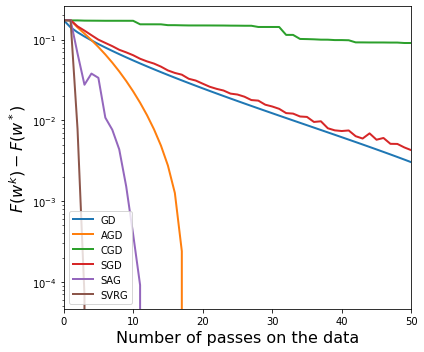

In [0]:
plt.figure(figsize=(6, 5))
plt.yscale("log")

for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives - obj_min    
    plt.plot(objectives_dist, label=name, lw=2)

plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()

### QUESTIONS

1. Compare the minimizers you obtain using the different algorithms, with a large and a small number of iterations. This can be done with `plt.stem` plots.
1. In linear regression and logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.
1. In linear regression and logistic regression, study the influence of the level of ridge penalization on the performance of the optimization algorithms. Explain.
1. (OPTIONAL) All algorithms can be modified to handle an objective of the form $f + g$ with $g$ separable and prox-capable. Modify all the algorithms and try them out for L1 penalization $f(w) = \lambda \sum_{j=1}^d |w_j|$.

QUESTION 1 \\

We plot mimimum values of the loss for each descent method for a small and a large numbers of iterations ($iter = 50$ or $iter = 1000$).

In [0]:
# Answer

# question 1
# small number of iterations
callback_small = inspector(model, n_iter=50, verbose=False)
w_gd = gd(model, w0, n_iter=50, callback=callback_small, verbose=False)
w_agd = agd(model, w0, n_iter=50, callback=callback_small, verbose=False)
w_cgd = cgd(model, w0, n_iter=50, callback=callback_small, verbose=False)
w_sgd = sgd(model, w0, idx_samples, n_iter=50, step=1e-2, callback=callback_small, verbose=False)
w_sag = sag(model, w0, idx_samples, n_iter=50, step=1 / model.lip_max(), callback=callback_small, verbose=False)
w_svrg = svrg(model, w0, idx_samples, n_iter=50, step=1 / model.lip_max(), callback=callback_small, verbose=False)
names = ["GD", "AGD", "CGD", "SGD", "SAG", "SVRG"]
w_min = [model.loss(w_gd), model.loss(w_agd), model.loss(w_cgd), model.loss(w_sgd), model.loss(w_sag), model.loss(w_svrg)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


[]

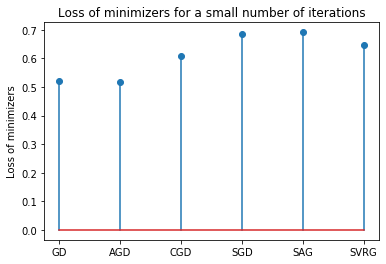

In [0]:
plt.stem(names, w_min)
plt.ylabel("Loss of minimizers")
plt.title("Loss of minimizers for a small number of iterations")
plt.plot()

We can see that the GD and AGD algorithms are the two most efficient ones with a small number of iterations.

In [0]:
# question 1
# large number of iterations
callback_long = inspector(model, n_iter=1000, verbose=False)
w_gd = gd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
w_agd = agd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
w_sgd = sgd(model, w0, idx_samples, n_iter=1000, step=1e-2, callback=callback_long, verbose=False)
w_sag = sag(model, w0, idx_samples, n_iter=1000, step= 1 / model.lip_max(), callback=callback_long, verbose=False)
w_svrg = svrg(model, w0, idx_samples, n_iter=1000, step= 1 / model.lip_max(), callback=callback_long, verbose=False)
names = ["GD", "AGD", "CGD", "SGD", "SAG", "SVRG"]
w_min = [model.loss(w_gd), model.loss(w_agd), model.loss(w_cgd), model.loss(w_sgd), model.loss(w_sag), model.loss(w_svrg)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


[]

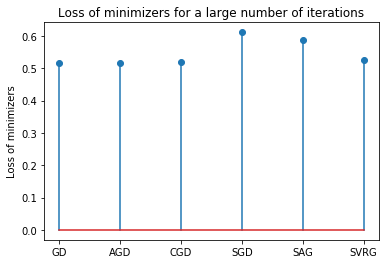

In [0]:
plt.stem(names, w_min)
plt.ylabel("Loss of minimizers")
plt.title("Loss of minimizers for a large number of iterations")
plt.plot()

Once again, the GD and the AGD algorithms are the two most efficient ones for a large number of iterations. Besides, by comparison with the previous plot, we can notice that minimizers found for each algorithm is better with a large number of iterations. This is consistent.

QUESTION 2 \\

To study the influence of the correlation of the features on the performance of the optimization algorithms, we plot $F(w^k) - F(w^*)$ for each algorithm for different value of  correlation. Correlation varies between $-1$ and $1$, but results are symetric with respect to $0$, so we focus on the interval $[0,1]$. \\

To compute $F(w^*)$, we use the Coordinate Descent Gradient algorithm with a large number of iterations because the previous question shows that it was the best approximation of the mimimum of the loss.

In [0]:
# question 2
# linear model
from scipy.optimize import check_grad

tab_corr = []
res_gd = []
res_agd = []
res_cgd = []
res_sgd = []
res_sag = []
res_svrg = []

for i in range(11):
  X, y = simu_linreg(w0, corr=i/10)
  model = ModelLinReg(X, y, strength=1e-3)

  w = np.random.randn(n_features)

  callback_long1 = inspector(model, n_iter=1000, verbose=False)
  w_cgd1 = cgd(model, w0, n_iter=1000, callback=callback_long1, verbose=False)
  obj_min = callback_long1.objectives[-1]

  callback_long = inspector(model, n_iter=50, verbose=False)
  w_gd = gd(model, w0, n_iter=50, callback=callback_long, verbose=False)
  w_agd = agd(model, w0, n_iter=50, callback=callback_long, verbose=False)
  w_cgd = cgd(model, w0, n_iter=50, callback=callback_long, verbose=False)
  w_sgd = sgd(model, w0, idx_samples, n_iter=50, step=1e-2, callback=callback_long, verbose=False)
  w_sag = sag(model, w0, idx_samples, n_iter=50, step= 1 / model.lip_max(), callback=callback_long, verbose=False)
  w_svrg = svrg(model, w0, idx_samples, n_iter=50, step= 1 / model.lip_max(), callback=callback_long, verbose=False)

  tab_corr.append(i/10)
  res_gd.append(model.loss(w_gd) - obj_min)
  res_agd.append(model.loss(w_agd) - obj_min)
  res_cgd.append(model.loss(w_cgd) - obj_min)
  res_sgd.append(model.loss(w_sgd)- obj_min)
  res_sag.append(model.loss(w_sag) - obj_min)
  res_svrg.append(model.loss(w_svrg) - obj_min)

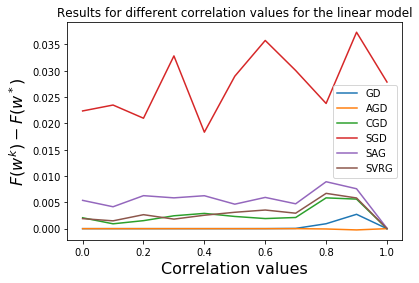

In [0]:
plt.plot(tab_corr, res_gd, label="GD")
plt.plot(tab_corr, res_agd, label="AGD")
plt.plot(tab_corr, res_cgd, label="CGD")
plt.plot(tab_corr, res_sgd, label="SGD")
plt.plot(tab_corr, res_sag, label="SAG")
plt.plot(tab_corr, res_svrg, label="SVRG")

plt.title("Results for different correlation values for the linear model")
plt.xlabel("Correlation values", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend()
plt.show()

We see that, for the linear model, the correlation of the features seems to have roughly no impact on algorithms.  \\
The influence on the SGD algorithm seems random, and no general conclusion can be drawn. 



In [0]:
# question 2
# logistic model
from scipy.optimize import check_grad

tab_corr = []
res_gd = []
res_agd = []
res_cgd = []
res_sgd = []
res_sag = []
res_svrg = []

for i in range(11):
  X, y = simu_logreg(w0, corr=i/10)
  model = ModelLogReg(X, y, strength=1e-3)

  w = np.random.randn(n_features)

  callback_long = inspector(model, n_iter=1000, verbose=False)
  w_cgd1 = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
  obj_min = callback_long.objectives[-1]

  callback_long1 = inspector(model, n_iter=50, verbose=False)
  w_gd = gd(model, w0, n_iter=50, callback=callback_long1, verbose=False)
  res_gd.append(callback_long1.objectives[-1] - obj_min)
  
  callback_long2 = inspector(model, n_iter=50, verbose=False)
  w_agd = gd(model, w0, n_iter=50, callback=callback_long2, verbose=False)
  res_agd.append(callback_long2.objectives[-1] - obj_min)

  callback_long3 = inspector(model, n_iter=50, verbose=False)
  w_cgd = cgd(model, w0, n_iter=50, callback=callback_long3, verbose=False)
  res_cgd.append(callback_long3.objectives[-1] - obj_min)

  callback_long4 = inspector(model, n_iter=50, verbose=False)
  w_sgd = sgd(model, w0, idx_samples, n_iter=50*model.n_samples, step=1e-2, callback=callback_long4, verbose=False)
  res_sgd.append(callback_long4.objectives[-1] - obj_min)

  callback_long5 = inspector(model, n_iter=50, verbose=False)
  w_sag = sag(model, w0, idx_samples, n_iter=50*model.n_samples, step=1 / model.lip_max(), callback=callback_long5, verbose=False)
  res_sag.append(callback_long5.objectives[-1] - obj_min)

  callback_long6 = inspector(model, n_iter=50, verbose=False)
  w_svrg = svrg(model, w0,idx_samples, n_iter=50*model.n_samples, step=1 / model.lip_max(), callback=callback_long6, verbose=False)
  res_svrg.append(callback_long6.objectives[-1] - obj_min)

  tab_corr.append(i/10)
  
  

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


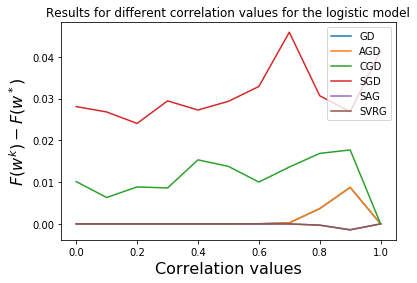

In [0]:
plt.plot(tab_corr, res_gd, label="GD")
plt.plot(tab_corr, res_agd, label="AGD")
plt.plot(tab_corr, res_cgd, label="CGD")
plt.plot(tab_corr, res_sgd, label="SGD")
plt.plot(tab_corr, res_sag, label="SAG")
plt.plot(tab_corr, res_svrg, label="SVRG")

plt.title("Results for different correlation values for the logistic model")
plt.xlabel("Correlation values", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend()
plt.show()

For the logistic model, we can make the same conclusions : the correlation does not seem to have an impact on the performances of algorithms.

QUESTION 3 \\

To study the influence of the level of ridge penalization on the performance of the optimization algorithms, we plot the loss of minizers of each algorithm for different value of the penalization, varying between $10^{-5}$ and $1$. In order to represent results correctly, we choose to use a logaritmic scale.

In [0]:
# question 3
# linear model
from scipy.optimize import check_grad

tab_strength = [1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1]
res_gd = []
res_agd = []
res_cgd = []
res_sgd = []
res_sag = []
res_svrg = []

for i in tab_strength:
  X, y = simu_linreg(w0, corr=0.6)
  model = ModelLinReg(X, y, strength=i)

  w = np.random.randn(n_features)

  callback_long = inspector(model, n_iter=1000, verbose=False)
  w_gd = gd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
  w_agd = agd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
  w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
  w_sgd = sgd(model, w0, idx_samples, n_iter=1000, step=1e-2, callback=callback_long, verbose=False)
  w_sag = sag(model, w0, idx_samples, n_iter=1000, step= 1 / model.lip_max(), callback=callback_long, verbose=False)
  w_svrg = svrg(model, w0, idx_samples, n_iter=1000, step= 1 / model.lip_max(), callback=callback_long, verbose=False)

  res_gd.append(model.loss(w_gd))
  res_agd.append(model.loss(w_agd))
  res_cgd.append(model.loss(w_cgd))
  res_sgd.append(model.loss(w_sgd))
  res_sag.append(model.loss(w_sag))
  res_svrg.append(model.loss(w_svrg))

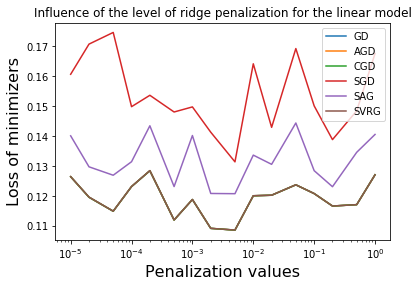

In [0]:
plt.plot(tab_strength, res_gd, label="GD")
plt.plot(tab_strength, res_agd, label="AGD")
plt.plot(tab_strength, res_cgd, label="CGD")
plt.plot(tab_strength, res_sgd, label="SGD")
plt.plot(tab_strength, res_sag, label="SAG")
plt.plot(tab_strength, res_svrg, label="SVRG")

plt.title("Influence of the level of ridge penalization for the linear model")
plt.xscale('log')
plt.xlabel("Penalization values", fontsize=16)
plt.ylabel("Loss of minimizers", fontsize=16)
plt.legend()
plt.show()

In [0]:
# question 3
# logistic model
from scipy.optimize import check_grad

tab_strength = [1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1]
res_gd = []
res_agd = []
res_cgd = []
res_sgd = []
res_sag = []
res_svrg = []

for i in tab_strength:
  X, y = simu_logreg(w0, corr=0.6)
  model = ModelLogReg(X, y, strength=i)

  w = np.random.randn(n_features)

  callback_long = inspector(model, n_iter=1000, verbose=False)
  w_gd = gd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
  w_agd = agd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
  w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
  w_sgd = sgd(model, w0, idx_samples, n_iter=1000, step=1e-2, callback=callback_long, verbose=False)
  w_sag = sag(model, w0, idx_samples, n_iter=1000, step= 1 / model.lip_max(), callback=callback_long, verbose=False)
  w_svrg = svrg(model, w0, idx_samples, n_iter=1000, step= 1 / model.lip_max(), callback=callback_long, verbose=False)

  res_gd.append(model.loss(w_gd))
  res_agd.append(model.loss(w_agd))
  res_cgd.append(model.loss(w_cgd))
  res_sgd.append(model.loss(w_sgd))
  res_sag.append(model.loss(w_sag))
  res_svrg.append(model.loss(w_svrg))

In [0]:
plt.plot(tab_strength, res_gd, label="GD")
plt.plot(tab_strength, res_agd, label="AGD")
plt.plot(tab_strength, res_cgd, label="CGD")
plt.plot(tab_strength, res_sgd, label="SGD")
plt.plot(tab_strength, res_sag, label="SAG")
plt.plot(tab_strength, res_svrg, label="SVRG")

plt.title("Influence of the level of ridge penalization for the logistic model")
plt.xscale('log')
plt.xlabel("Penalization values", fontsize=16)
plt.ylabel("Loss of minimizers", fontsize=16)
plt.legend()
plt.show()